<h1 align="center">Planet: Understanding the Amazon from Space</h1>
![](https://kaggle2.blob.core.windows.net/competitions/kaggle/6322/logos/header.png)
<h2 align="center">Using satellite data to track the human footprint in the Amazon rainforest</h2>


In [1]:
%autosave 1800

Autosaving every 1800 seconds


In [2]:
import sys
import subprocess
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib
matplotlib.rcParams['font.sans-serif'].insert(0, 'Liberation Sans')
matplotlib.rcParams['font.sans-serif'].insert(0, 'Arial')
matplotlib.rcParams['font.family'] = 'sans-serif'
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from skimage import io
import scipy
from scipy import ndimage
from IPython.display import display
import rasterio # reads and writes geospatial raster datasets

# Time to get straight into data:
Set PLANET_KAGGLE_ROOT to the directory where you've downloaded the TIFF and JPEG zip files, and accompanying CSVs.

In [3]:
PLANET_KAGGLE_ROOT = os.path.abspath('/resources/data/Kaggle/amazon/')

print('# File sizes')
for f in os.listdir('/resources/data/Kaggle/amazon/'):
    if not os.path.isdir('/resources/data/Kaggle/amazon/' + f):
        print(f.ljust(30) + str(round(os.path.getsize('/resources/data/Kaggle/amazon/' + f) / 1000000, 2)) + 'MB')
    else:
        sizes = [os.path.getsize('/resources/data/Kaggle/amazon/'+f+'/'+x)/1000000 for x in os.listdir('/resources/data/Kaggle/amazon/' + f)]
        print(f.ljust(30) + str(round(sum(sizes), 2)) + 'MB' + ' ({} files)'.format(len(sizes)))

# File sizes
test-tif.tar                  21958.48MB
test-tif                      21930.25MB (40669 files)
test-jpg                      637.8MB (40669 files)
train-tif                     21819.98MB (40479 files)
train.csv                     1.43MB
sample_submission.csv         1.94MB
train-jpg                     634.68MB (40479 files)
train-tif.tar                 21848.07MB


In [4]:
label_csv = os.path.join('/resources/data/Kaggle/amazon/test-tif', '/resources/data/Kaggle/amazon/train.csv')

In [5]:
label_csv

'/resources/data/Kaggle/amazon/train.csv'

In [6]:
labels_df =  pd.read_csv(label_csv)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


- we have 40k images for training, and 40k images for testing. 
- The jpegs are on average **15KB**, and the tifs are on average **538KB**. 
- The JPEGs seem a little on the small side, but TIFFs look like they will retain most of the quality.

Let's take a look at the train.csv:

# Training data

In [7]:
labels_df = pd.read_csv("/resources/data/Kaggle/amazon/train.csv")
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [8]:
labels_df.tail()

,image_name,tags
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road
40478,train_40478,agriculture cultivation partly_cloudy primary


In [9]:
labels_df.describe()

,image_name,tags
count,40479,40479
unique,40479,458
top,train_21471,clear primary
freq,1,13636


# Tag Counts
Let's count all the tags.


In [11]:
all_labels = [label for sublist in list(labels_df['tags'].apply(lambda row: row.split(' ')).values) for label in sublist]
print('Total of {} non-unique tags in all training images'.format(len(all_labels)))
print('average number of labels per image {}'.format(1.0*len(all_labels)/labels_df.shape[0]))

Total of 116484 non-unique tags in all training images
average number of labels per image 2.8776402579115095


Let's do the actual counting by using pandas dataFrame groupby method.

In [12]:
labels_counted_and_sorted = pd.DataFrame({'tag': all_labels}).groupby('tag').size().reset_index().sort_values(0, ascending=False)
labels_counted_and_sorted.head()

,tag,0
12,primary,37840
5,clear,28203
0,agriculture,12338
13,road,8076
16,water,7262


There are only a few tags, that occur very often in the data:
- primary
- clear
- agriculture
- road
- and water.

/resources/common/.virtualenv/python3/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



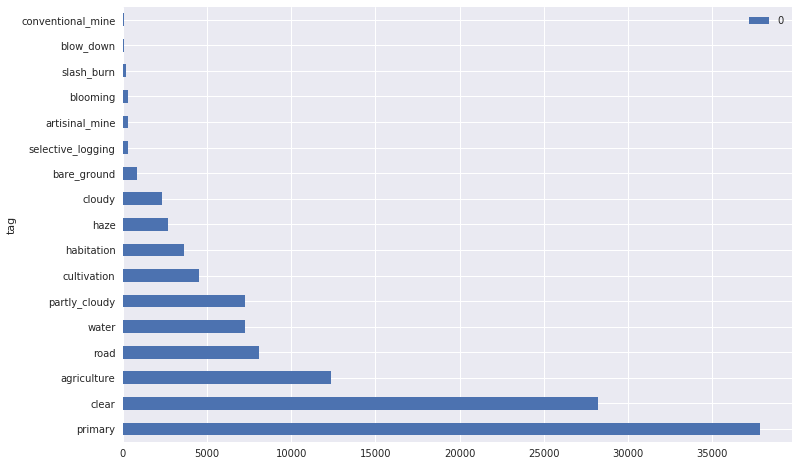

In [13]:
labels_counted_and_sorted.plot.barh(x='tag', y=0, figsize=(12, 8))

From this tag distribution it will most likely be relatively easy to predict the often occuring tags and comparatively very hard to get the low sampled tags correct.

# Sample Submission from training tag counts

Let's take the training tag distribution and sample from it as a prior for our test data. For that we will configure a bernoulli distribution for each sample with the observed training frequency and sample from that for each test image. With that we'll generate a submission without ever looking at the images.

In [14]:
from scipy.stats import bernoulli

In [17]:
sample = pd.read_csv('/resources/data/Kaggle/amazon/sample_submission.csv')
sample.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [18]:
label_probas = labels_counted_and_sorted[0].values/labels_counted_and_sorted[0].values.sum()
indicators = np.hstack([bernoulli.rvs(p, 0, sample.shape[0]).reshape(sample.shape[0], 1) for p in label_probas])
indicators = np.array(indicators)
indicators.shape

(40669, 17)

In [19]:
indicators[:10,:]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [20]:
sorted_labels = labels_counted_and_sorted['tag'].values
all_test_labels = []
for index in range(indicators.shape[0]):
    all_test_labels.append(' '.join(list(sorted_labels[np.where(indicators[index, :] == 1)[0]])))
len(all_test_labels)

40669

In [21]:
sample['tags'] = all_test_labels
sample.head()

,image_name,tags
0,test_0,
1,test_1,primary clear
2,test_2,clear
3,test_3,water cultivation
4,test_4,road


In [23]:
sample.to_csv('/resources/data/Kaggle/amazon/bernoulli_submission.csv', index=False)

The training metadata is super basic. It looks like we are just given names and corresponding tags. Let's parse them and do some analysis

In [ ]:
labels = labels_df['tags'].apply(lambda x: x.split(' '))

In [ ]:
labels[1]

In [ ]:
from collections import Counter, defaultdict
counts = Counter()
for label in labels:
    counts += Counter(label)

In [ ]:
# Build list with unique labels
labels_list = list(counts.keys())
len(labels_list)

In [ ]:
# Add one-hot encoded features for every label
for label in labels_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    
# display head
labels_df.head()

In [ ]:
data = [go.Bar(x = list(counts.keys()), y=list(counts.values()))]
layout = dict(height=800, width=800, title='Distribution of training labels')
fig = dict(data=data, layout=layout)
py.iplot(data)

In [ ]:
# Same Histogram of label instances
labels_df[labels_list].sum().sort_values().plot.bar()

# Co-Occurence Matrix
A co-occurrence matrix stores the count of how often a particular pair of things occurred together.   

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def make_coocurence_matrix(labels):
    numeric_df = labels_df[labels];
    c_matrix = numeric_df.T.dot(numeric_df)
    scaler = MinMaxScaler()
    c_matrix.loc[:,:] = scaler.fit_transform(c_matrix) 
    data = [go.Heatmap(z=c_matrix.T.values.tolist(), x = list(c_matrix[:0][:]), y=list(c_matrix[:0][:]), colorscale='Viridis')]
    layout = go.Layout(height = 600, width =500, title='Co-occurence matrix of training labels')
    fig = dict(data=data, layout=layout)
    py.iplot(data)
    return c_matrix


# Compute the occurence matrix
make_coocurence_matrix(labels_list)


In [ ]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
make_coocurence_matrix(weather_labels)

In [ ]:
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation']
make_coocurence_matrix(land_labels)

In [ ]:
rare_labels = [label for label in labels_list if labels_df[labels_list].sum()[label] < 2000]
make_coocurence_matrix(rare_labels)

In this context, **this co-occurence matrix shows what percentage of the X label also has the Y label**.
# Images

## Helper function to select sample images

In [ ]:
from six import string_types
def sample_images(tags, n=None):
    """Randomly sample n images with the specified tags"""
    condition = True
    if isinstance(tags, string_types):
        raise ValueError("Pass a list of tags, not a single tag.")
    for tag in tags:
        condition = condition & labels_df[tag] == 1
        
    if n is not None:
        return labels_df[condition].sample(n)
    
    else:
        return labels_df[condition]

## Helper function to find image

In [ ]:
def find_image(filename):
    
    
    for dirname in os.listdir('/resources/data/Kaggle/amazon/'):
        path = os.path.abspath(os.path.join('/resources/data/Kaggle/amazon/', dirname, filename))
        if os.path.exists(path):
            print('Found Image {}'.format(path))
            return path
        else:
            print('Oops! Imag not found at {}'.format(path))
            

## Helper function to load an image

In [ ]:
def load_image(filename):
    """Return a 4D (r, g, b, nir) numpy array with the data in the specified TIFF filename."""
    path = find_image(filename)
    if path:
        with rasterio.open(path) as src:
            b, g, r, nir = src.read()
            return np.dstack([r, g, b, nir])
    else:
        print('Load Failed: could not find image {}'.format(path))

Let's plot some images and look at their histogram of pixel values in each channel.

In [ ]:
image_path = sample_images(['primary', 'water', 'road'], n=1)['image_name'].iloc[0]
rgbn_image = load_image(image_path+'.tif')
rgb_image = rgbn_image[:, :, :3]

In [ ]:
r, g, b, nir = rgbn_image[:, :, 0], rgbn_image[:, :, 1], rgbn_image[:, :, 2], rgbn_image[:, :, 3]

In [ ]:
for slice_, name, color in ((r, 'r', 'red'), (g,'g', 'green'), (b, 'b', 'blue'), (nir, 'nir', 'magenta')):
    plt.hist(slice_.ravel(), bins=100, range=[0, rgb_image.max()], label=name, histtype='step')
    
plt.legend()
plt.show()

Let's look at each channel individually:


In [ ]:
fig = plt.figure(figsize=(12, 8))
for i, (x, c) in enumerate (((r, 'r'), (g, 'g'), (b, 'b'), (nir, 'near-ir'))):
    a = fig.add_subplot(1, 4, i+1)
    a.set_title(c)
    plt.imshow(x)

In [ ]:
plt.imshow(rgb_image)